# Load Imporatant Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import datetime

# Sampling function from GP with a fixed Kernel

In [ ]:
class CNPRegressionDescription:
    """ Constructor Class to store the context and target data points
    """
    def __init__(self, query, target_y):
        self.query = query
        self.target_y = target_y


class GPCurvesReader(object):
    """ Class to generate curves using a Gaussian Process(GP).
    """

    def __init__(
        self,
        batch_size,
        max_num_context,
        x_size=1,
        y_size=1,
        l1_scale=0.4,
        sigma_scale=1.0,
        testing=False,
    ):
        """Creating a dataset of functions sampled from the GP.

        Args:
          batch_size: No. of functions to be sampled.
          max_num_context: Max. no. of training points.
          x_size: Dimension of input vector.
          y_size: Dimension of output vector.
          l1_scale: Length scale of kernel.
          sigma_scale: Variance scale.
          testing: Boolean to check training or testing phase.
        """
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._x_size = x_size
        self._y_size = y_size
        self._l1_scale = l1_scale
        self._sigma_scale = sigma_scale
        self._testing = testing

    def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
        """Function to evaluate least square Gaussian kernel.

        Args:
          xdata: input vector
          l1: length scale of kernel
          sigma_f: Variance scale
          sigma_noise: Noise to make Covariance matrix positive definite.

        Returns:
          The kernel output
        """
        num_total_points = xdata.shape[1]   # Total no. of input points

        x1 = xdata.unsqueeze(dim=1)         # Reshaping the input vector to a 4d matrix
        x2 = xdata.unsqueeze(dim=2)         # Reshaping the input vector to a 4d matrix

        # Difference of x1 and x2 of shape = [B, num_total_points, num_total_points, x_size]
        diff = x1 - x2

        # Norm of the difference matrix of shape = [B, y_size, num_total_points, num_total_points]
        norm = (diff[:, None, :, :, :] / l1[:, :, None, None, :]) ** 2
        norm = norm.sum(dim=-1)

        # Kernel output of shape = [B, y_size, num_total_points, num_total_points]
        kernel = (sigma_f ** 2)[:, :, None, None] * torch.exp(-0.5 * norm)

        # Addition of noise to make the kernel positive definite
        kernel += (sigma_noise ** 2) * torch.eye(num_total_points)

        return kernel

    def generate_curves(self):
        """Function to generate the individual functions sampled from the GP

        Returns:
          A `CNPRegressionDescription` object.
        """

        num_context = 5

        # In case of testing, creating a set of evenly distributed num_target points between [-2,2] to plot the function.
        if self._testing:
            num_target = 401
            num_total_points = num_target
            x_values = torch.linspace(start=-2, end=2, steps=num_target)
            x_values = (x_values.unsqueeze(dim=0).repeat([self._batch_size, 1]).unsqueeze(-1))

        # In case of training, creating random no. of target points and a set of randomly distributed num_total_points points between [-2,2]
        else:
            num_target = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))
            num_total_points = num_context + num_target
            x_values = (torch.rand((self._batch_size, num_total_points, self._x_size)) * 4 - 2)

        # Setting of kernel parameters
        l1 = torch.ones(self._batch_size, self._y_size, self._x_size) * self._l1_scale
        sigma_f = torch.ones(self._batch_size, self._y_size) * self._sigma_scale

        # Evaluation of the kernel of shape = [batch_size, y_size, num_total_points, num_total_points]
        kernel = self._gaussian_kernel(x_values, l1, sigma_f)

        # Cholesky decomposition of the kernel matrix
        cholesky = torch.cholesky(kernel.type(torch.DoubleTensor)).type(torch.FloatTensor)

        # Evaluation of y_values of shape = [batch_size, y_size, num_total_points, 1]
        y_values = torch.matmul(cholesky, torch.randn(self._batch_size, self._y_size, num_total_points, 1))

        # Reordering of the components of y_values to [batch_size, num_total_points, y_size]
        y_values = y_values.squeeze(3).permute([0, 2, 1])

        # Selection of target and random num_context points
        if self._testing:
            target_x = x_values
            target_y = y_values

            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context], :]
            context_y = y_values[:, idx[:num_context], :]

        else:
            target_x = x_values[:, : num_target + num_context, :]
            target_y = y_values[:, : num_target + num_context, :]

            # Select the observations
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)

        return CNPRegressionDescription(query=query, target_y=target_y)

# Encoder Class

In [ ]:
class DeterministicEncoder(nn.Module):
    def __init__(self, sizes):
        """ Constructor class for encoder
        """
        super(DeterministicEncoder, self).__init__()
        self.linears = [nn.Linear(sizes[i], sizes[i+1]) for i in range(len(sizes) - 1)]
        self.linears = nn.ModuleList(self.linears)

    def forward(self, context_x, context_y):
        """
        Function to encode the training set as a single vector

        Args:
            context_x:  Training x_values
            context_y:  Training y_values

        Returns:
            representation:
        """
        encoder_input = torch.cat((context_x, context_y), dim=-1) # Concatenating x and y labels
        batch_size, set_size, _ = encoder_input.shape             # Storing the batch_size and set_size from the encoder input
        x = encoder_input.view(batch_size * set_size, -1)

        # Applying ReLu activation function
        for linear in self.linears[:-1]:
            x = torch.relu(linear(x))
        x = self.linears[-1](x)

        # Mean of x stored as representation vector
        representation = x.view(batch_size, set_size, -1).mean(dim=1)

        return representation

# Decoder Class

In [ ]:
class DeterministicDecoder(nn.Module):
    def __init__(self, sizes):
        """ Constructor class of Decoder
        """
        super(DeterministicDecoder, self).__init__()
        self.linears = [nn.Linear(sizes[i], sizes[i+1]) for i in range(len(sizes) - 1)]
        self.linears = nn.ModuleList(self.linears)

    def forward(self, representation, target_x):
        """
        Function to return distribution of x

        Args:
            representation: output from encoder class
            target_x: Prediction x_values
        """
        batch_size, set_size, _ = target_x.shape    # Storing the batch_size and set_size from the target x_values
        representation = representation.unsqueeze(1).repeat([1, set_size, 1]) # Reshaping the dimensions of representation tensor
        decoder_input = torch.cat((representation, target_x), dim=-1)   # Concatenating the representation and target_x tensors
        x = decoder_input.view(batch_size * set_size, -1)

        # Applying ReLu activation function
        for linear in self.linears[:-1]:
            x = torch.relu(linear(x))
        x = self.linears[-1](x)

        decoder_output = x.view(batch_size, set_size, -1)

        mean, log_sigma = torch.split(decoder_output, 1, dim=-1)    # Mean of the decoder output
        sigma = 0.1 + 0.9 * torch.nn.functional.softplus(log_sigma) # Std. Dev. of the decoder output

        distribution = torch.distributions.normal.Normal(loc=mean, scale=sigma) # Prob. dist. of the Gaussian with mean and sigma parameters

        return distribution, mean, sigma

# Conditional Neural Process Model

In [ ]:
class DeterministicModel(nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes):
        """ Constructor class of the model
        """
        super(DeterministicModel, self).__init__()
        self._encoder = DeterministicEncoder(encoder_sizes)
        self._decoder = DeterministicDecoder(decoder_sizes)

    def forward(self, query, target_y=None):
        """ Function to encode and decode the training and testing data points
        """
        (context_x, context_y), target_x = query      # Reading the context and target values
        representation = self._encoder(context_x, context_y)  # Calling the encoder function for the query
        distribution, mean, sigma = self._decoder(representation, target_x) # Storing the distribution of the query

        log_p = None if target_y is None else distribution.log_prob(target_y) # Log of probability distribution
        return log_p, mean, sigma

# Plot Functions

In [ ]:
def plot_CNP_prediction(target_x, target_y, context_x, context_y, pred_y, var):
    """Plots the CNP predicted mean and variance along with context points

    Args:
      target_x: Target points.
      target_y: Target points.
      context_x: x_values of context points.
      context_y: y_values of context points.
      pred_y: Predicted y values for target points.
      var: Variance of predicted y values.
    """

    plt.figure(figsize=(10, 6))
    plt.plot(target_x[0], pred_y[0], "b", label="Predicted Mean", linewidth=2)
    plt.plot(target_x[0], target_y[0], "k:", label="Ground Truth", linewidth=2)
    plt.fill_between(target_x[0, :, 0], pred_y[0, :, 0] - var[0, :, 0], pred_y[0, :, 0] + var[0, :, 0], alpha=0.2, facecolor="#65c9f7", label="Predicted Variance",interpolate=True,)

    # Plot context points
    plt.scatter(context_x[0], context_y[0], color='black', label="Context Points", s=100)
    plt.xlabel("X", fontsize=14)
    plt.ylabel("Y", fontsize=14)
    plt.title("CNP Model", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()


In [ ]:
# Function to compute the kernel
def squared_exponential_kernel(points1, points2, params = [1.0, 1.0]):
    """
    Compute the squared exponential kernel between points in a 1D array.
    """
    sigma, length_scale = params
    # Compute pairwise squared Euclidean distances
    distances_squared = np.subtract.outer(points1, points2) ** 2

    # Compute kernel values using squared exponential formula
    kernel_values = sigma**2 * np.exp(-0.5 * distances_squared / length_scale**2)

    return kernel_values

# Define the log_likelihood function
def log_likelihood(y, X, params, noise_std):
    n = len(y)
    K = squared_exponential_kernel(X, X, params) # Call the Kernel function
    K += (noise_std**2) * np.eye(n)  # Add noise variance to the diagonal
    try:
        L = np.linalg.cholesky(K)  # Cholesky decomposition
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y)) # solve instead of inv
        log_likelihood_value = -0.5 * (y - np.zeros(n)).dot(alpha) - np.sum(np.log(np.diag(L))) - 0.5 * n * np.log(2 * np.pi)
    except np.linalg.LinAlgError:
        log_likelihood_value = -np.inf

    # print("noise_std:", noise_std, "negative-log-likelihood", "{:.4f}".format(-log_likelihood_value))
    return log_likelihood_value

# Define the Optimization Function
def obtain_noise(y, X, params, init_guess):
    # Define the negative log-likelihood function
    neg_log_likelihood = lambda noise: -log_likelihood(y, X, params, noise)
    # Optimize the negative log-likelihood function, provide bounds for numerical stability
    res = minimize(neg_log_likelihood, init_guess, bounds=[(1e-6, None)])
    return res.x

# Function to make predictions
def GP_predictions(y, X, Xstar, params, init_guess=1.0):
    # Obtain the Required Matrices
    noise_var = obtain_noise(y, X, params, init_guess) ** 2
    trained_kernel = noise_var * np.eye(X.shape[0]) + squared_exponential_kernel(X, X, params)
    test_kernel = noise_var * np.eye(Xstar.shape[0]) + squared_exponential_kernel(Xstar, Xstar, params)
    train_test_kernel = squared_exponential_kernel(X, Xstar, params)
    # For Prediction Mean
    L = np.linalg.cholesky(trained_kernel)  # Cholesky decomposition
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    predictive_mean = np.transpose(train_test_kernel) @ alpha
    # For Confidence Interval
    alpha_std = np.linalg.solve(L.T, np.linalg.solve(L, train_test_kernel))
    predictive_covar = test_kernel - np.transpose(train_test_kernel) @ alpha_std
    # Diagonal Term contains individual variance terms
    individual_variance = np.diagonal(predictive_covar)
    predictive_std = np.sqrt(individual_variance) # 2 * sigma
    return predictive_mean, predictive_std

In [ ]:
def plot_GP_prediction(target_x, target_y, context_x, context_y, pred_y, var):
    """Plots the GP predicted mean and variance along with context points.

    Args:
      target_x: Target points.
      target_y: Target points.
      context_x: x_values of context points.
      context_y: y_values of context points.
      pred_y: Predicted y values for target points.
      var: Variance of predicted y values.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(target_x[0], pred_y, "r", label="Predicted Mean", linewidth=2)
    plt.plot(target_x[0], target_y[0], "k:", label="Ground Truth", linewidth=2)
    plt.fill_between(
        target_x[0, :, 0],
        pred_y - var,
        pred_y + var,
        alpha=0.2,
        facecolor="#FFA07A",
        label="Predicted Variance",
        interpolate=True,
    )
    plt.fill_between(target_x[0, :, 0], pred_y - var, pred_y + var, alpha=0.2, facecolor="#FFA07A", label="Predicted Variance", interpolate=True,)


    # Plot context points
    plt.scatter(context_x[0], context_y[0], color='black', label="Context Points", s=100)
    plt.xlabel("X", fontsize=14)
    plt.ylabel("Y", fontsize=14)
    plt.title("GP Model", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()


# Conditional Neural Process Model for Function Regression

In [ ]:
# Parameter for training
TRAINING_ITERATIONS = int(2e5)
PLOT_AFTER = int(1e4)
MAX_CONTEXT_POINTS = 10

In [ ]:
# Setting the seed for reproducibility
torch.manual_seed(0)
# Generating training dataset
dataset_train = GPCurvesReader(batch_size=64, max_num_context=MAX_CONTEXT_POINTS)
# Generating testing dataset
dataset_test = GPCurvesReader(batch_size=100, max_num_context=MAX_CONTEXT_POINTS, testing=True)

In [ ]:
# Dimensions for encoder and decoder inputs
d_x, d_in, representation_size, d_out = 1, 2, 128, 2
encoder_sizes = [d_in, 128, 128, 128, representation_size]
decoder_sizes = [representation_size + d_x, 128, 128, 2]

# Modelling and optimizing the parameters using Adam optimizer
model = DeterministicModel(encoder_sizes, decoder_sizes)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

<ipython-input-2-3cbb3c1d7ded>:104: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1692.)
  cholesky = torch.cholesky(kernel.type(torch.DoubleTensor)).type(torch.FloatTensor)


2024-04-23 09:08:17, Iteration: 0, test loss: 1.5836611986160278


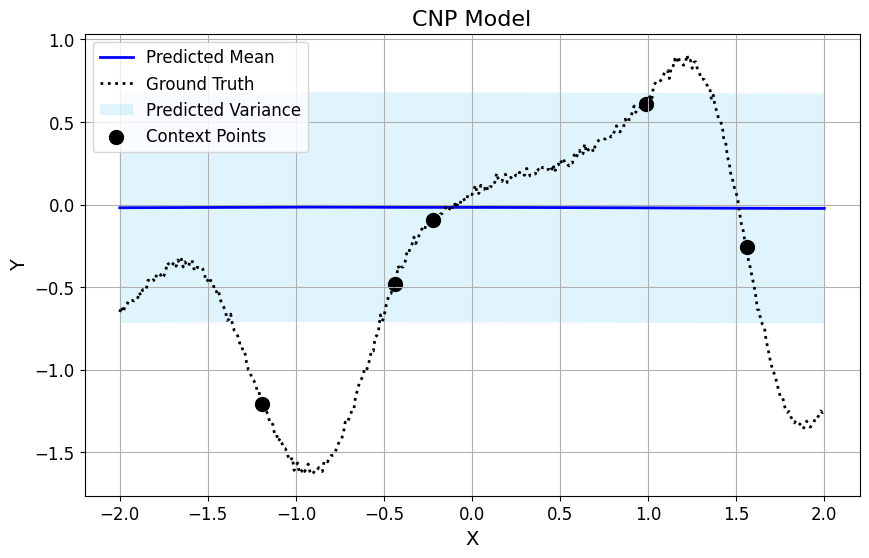

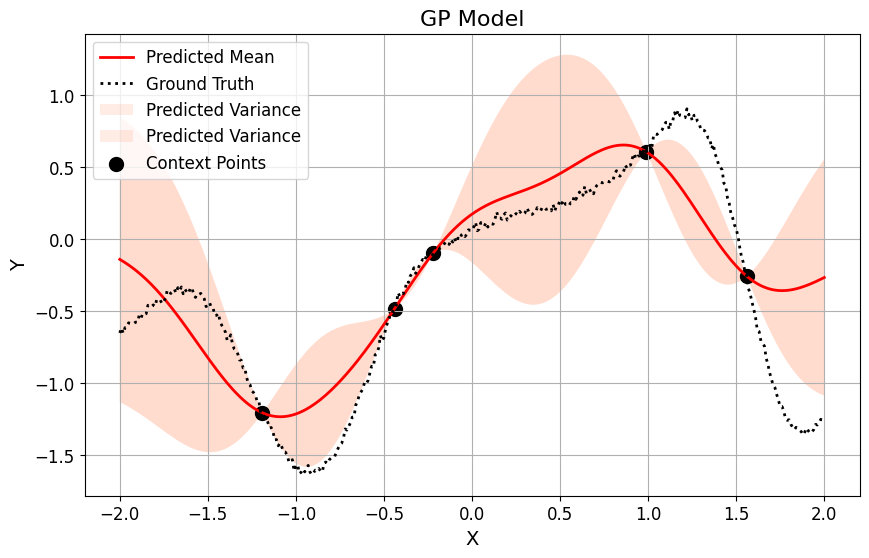

2024-04-23 09:10:09, Iteration: 10000, test loss: 0.9732137322425842


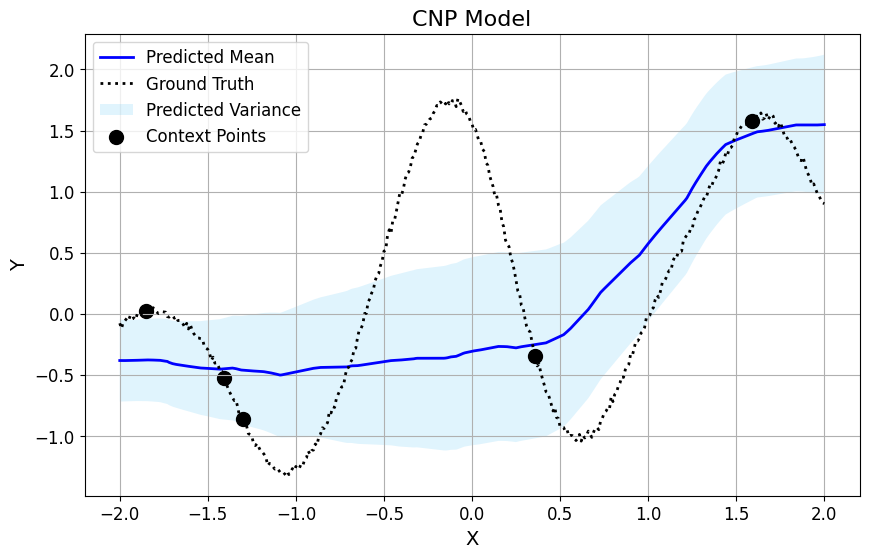

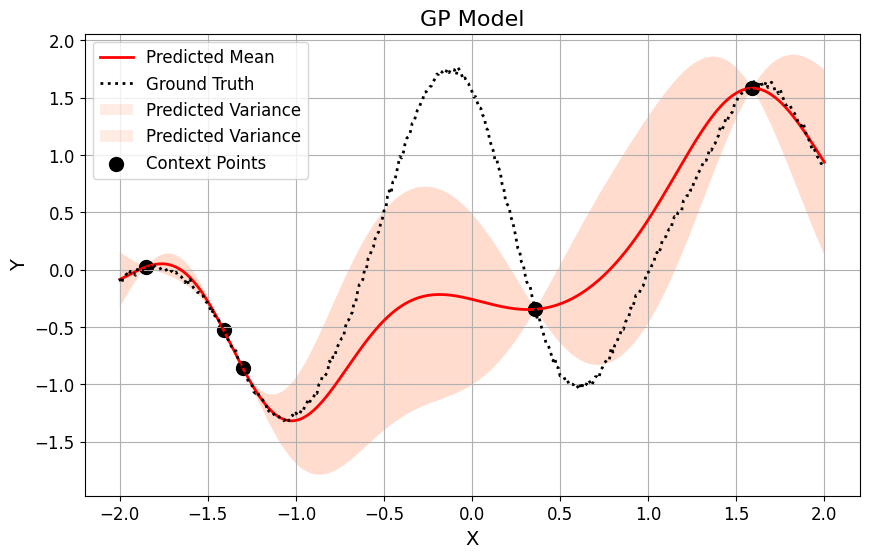

2024-04-23 09:11:57, Iteration: 20000, test loss: 0.8032586574554443


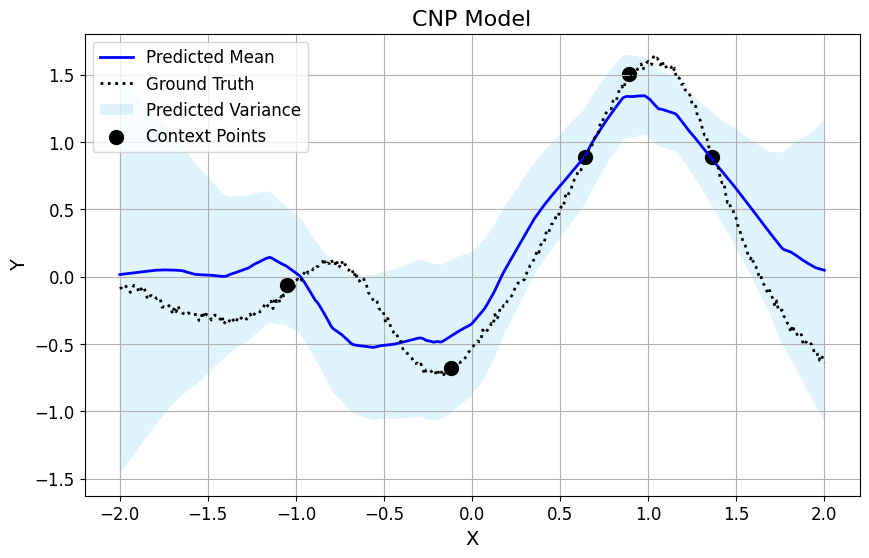

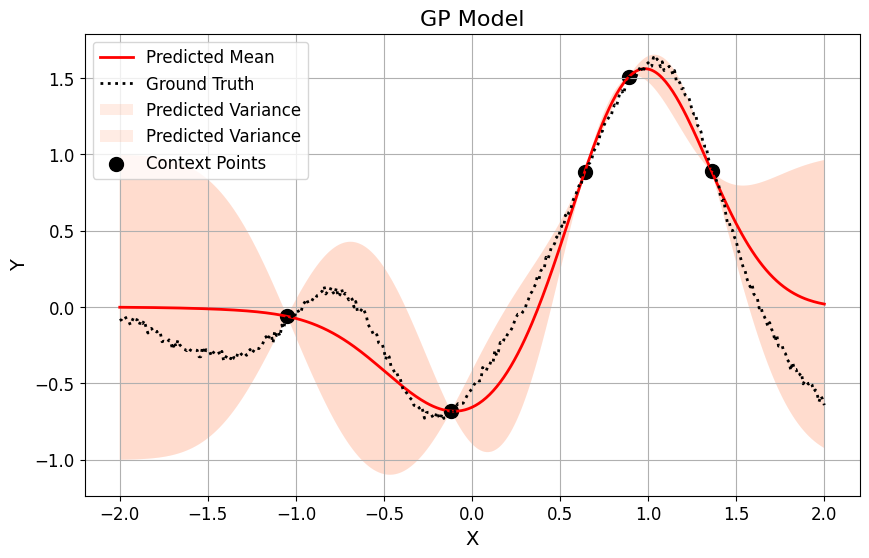

2024-04-23 09:13:50, Iteration: 30000, test loss: 1.1348042488098145


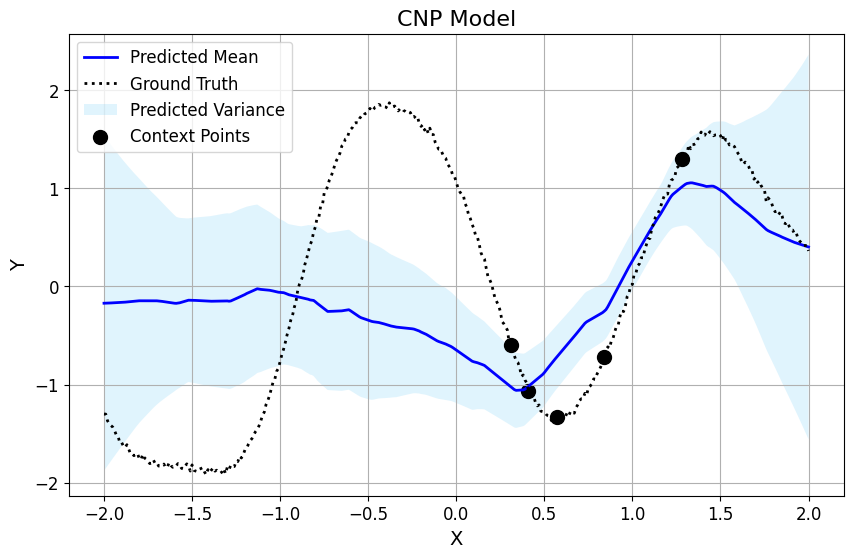

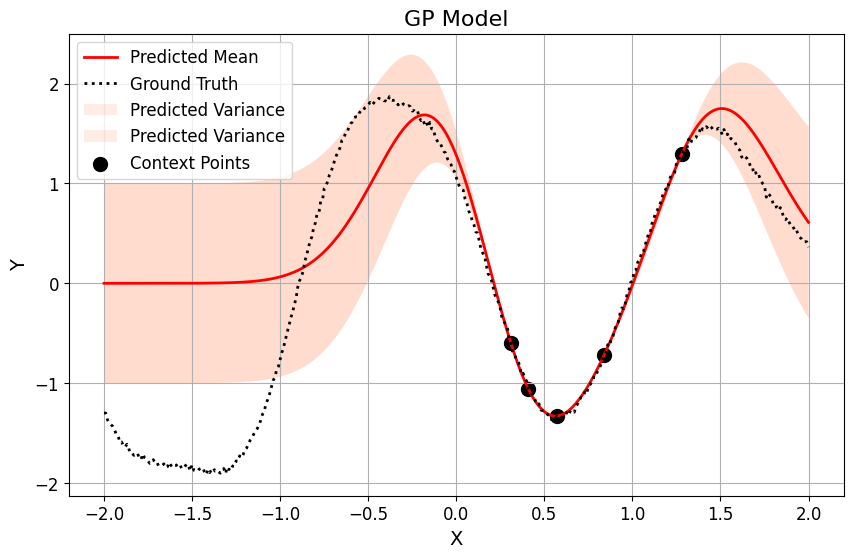

2024-04-23 09:15:40, Iteration: 40000, test loss: 0.7425798177719116


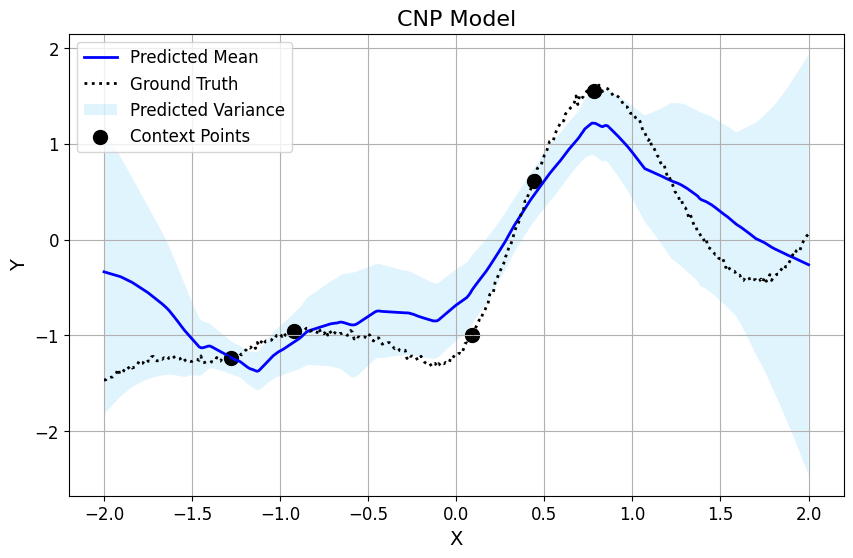

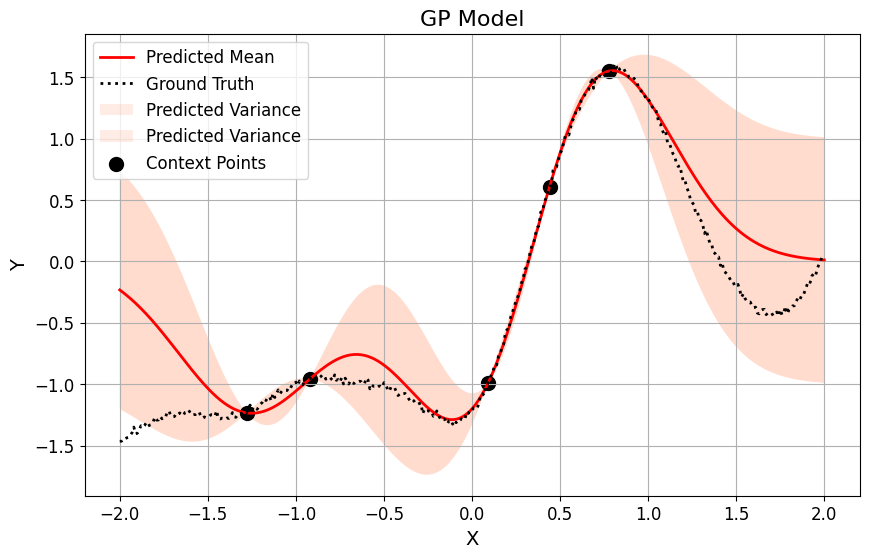

2024-04-23 09:17:31, Iteration: 50000, test loss: 0.7799904346466064


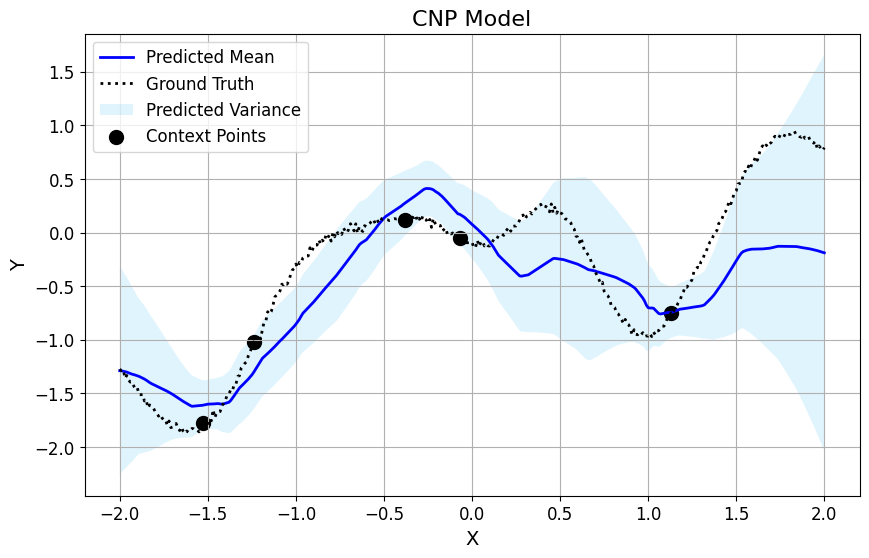

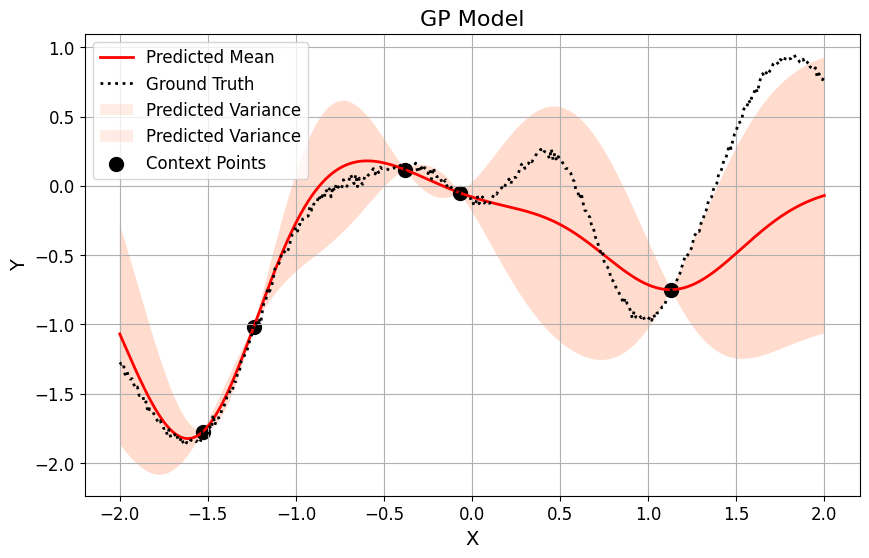

2024-04-23 09:19:24, Iteration: 60000, test loss: 1.1048365831375122


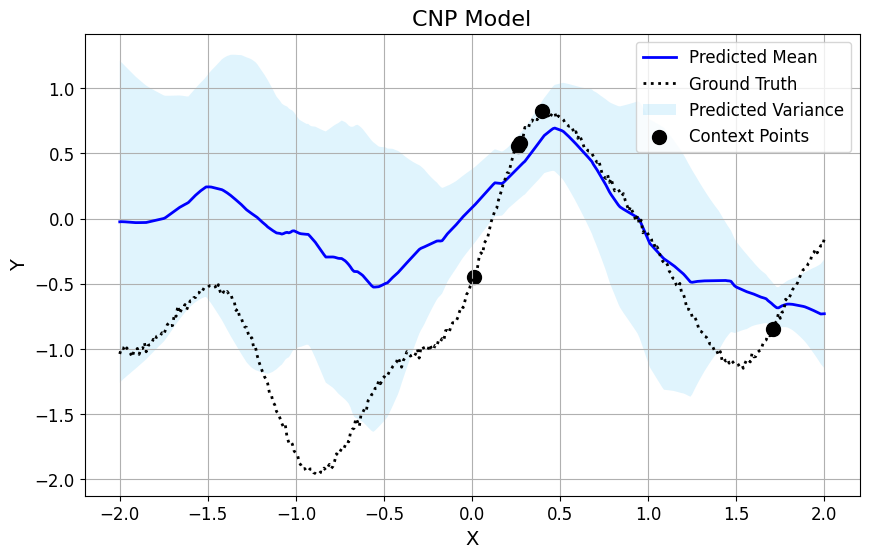

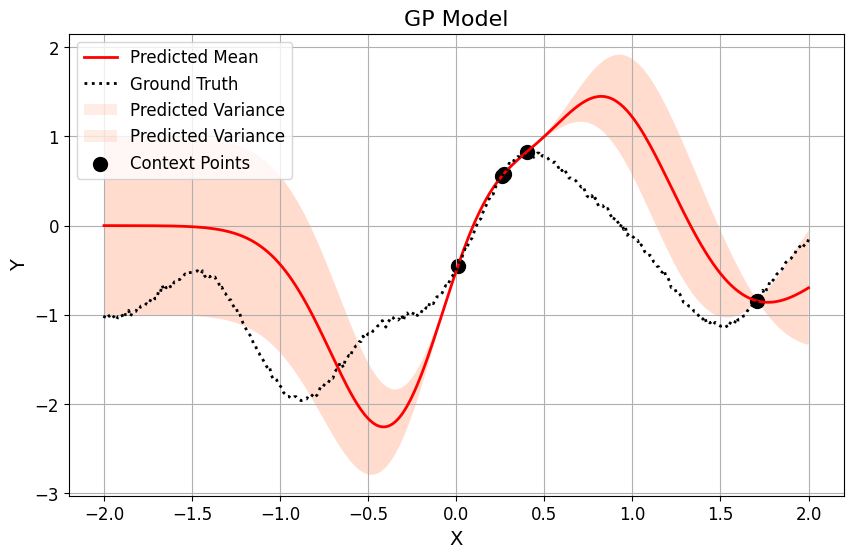

2024-04-23 09:21:16, Iteration: 70000, test loss: 0.6950691938400269


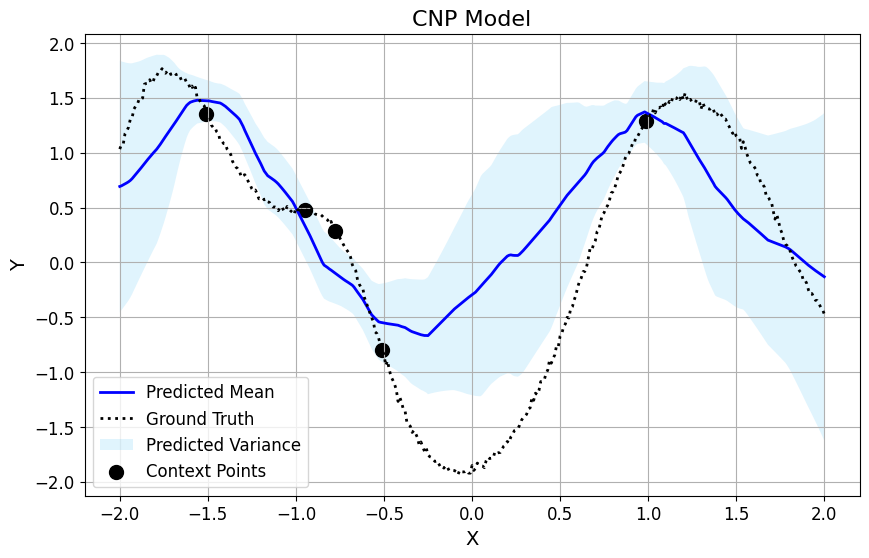

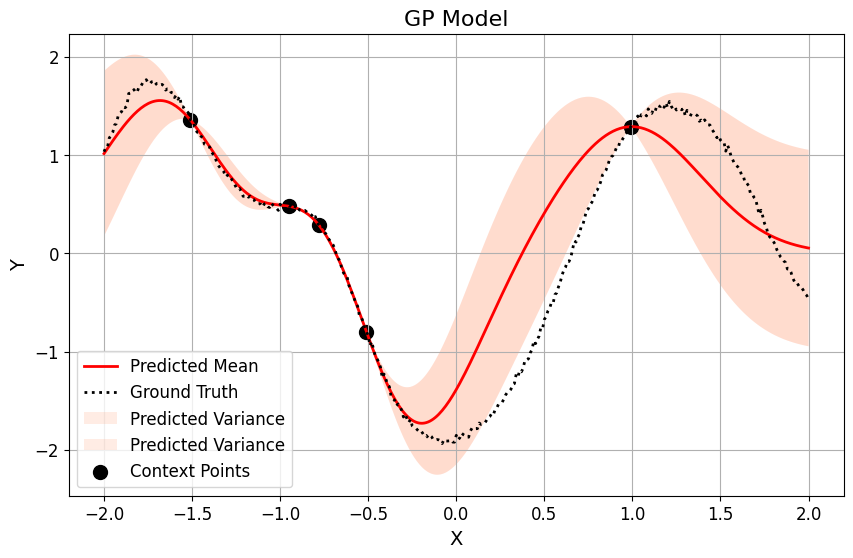

2024-04-23 09:23:11, Iteration: 80000, test loss: 0.6706156730651855


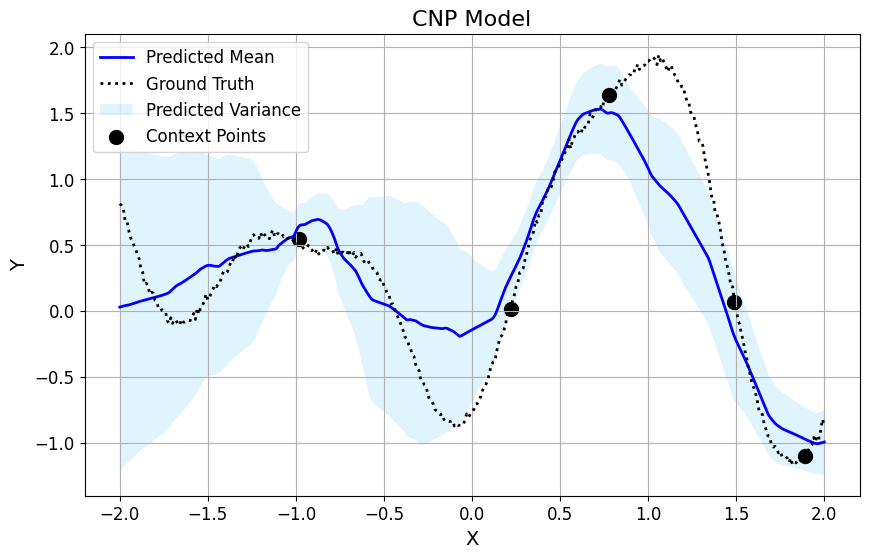

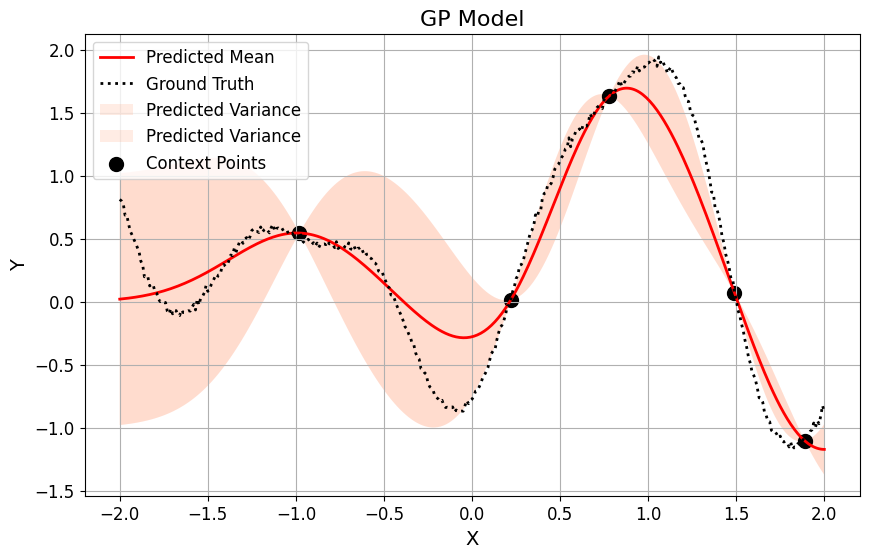

2024-04-23 09:25:04, Iteration: 90000, test loss: 0.6742528676986694


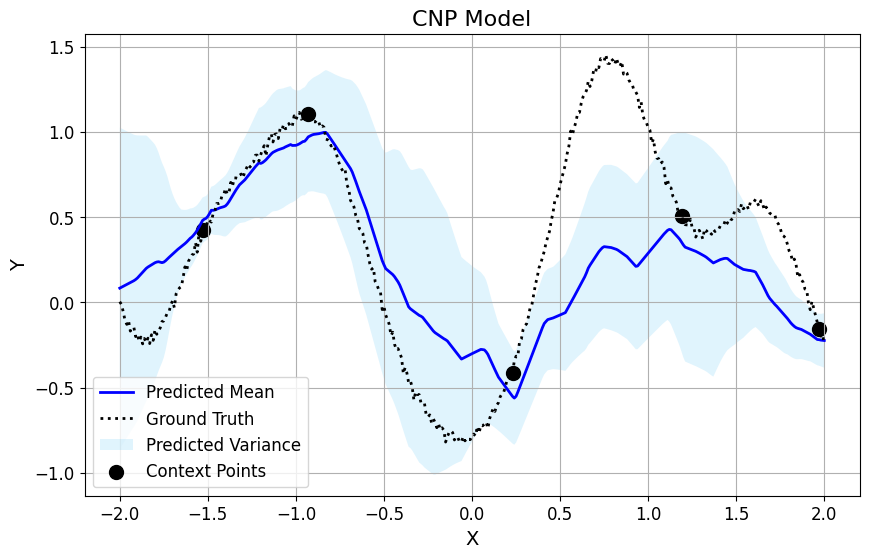

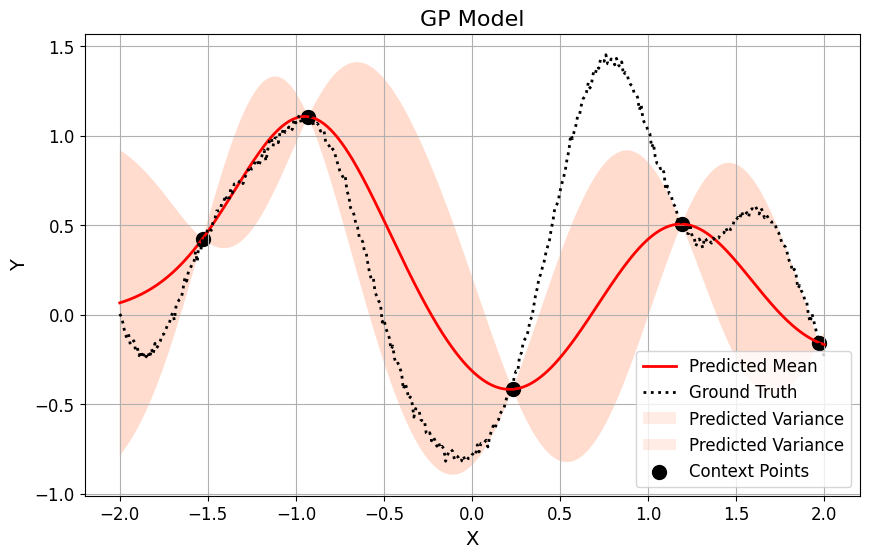

2024-04-23 09:27:01, Iteration: 100000, test loss: 0.8293901085853577


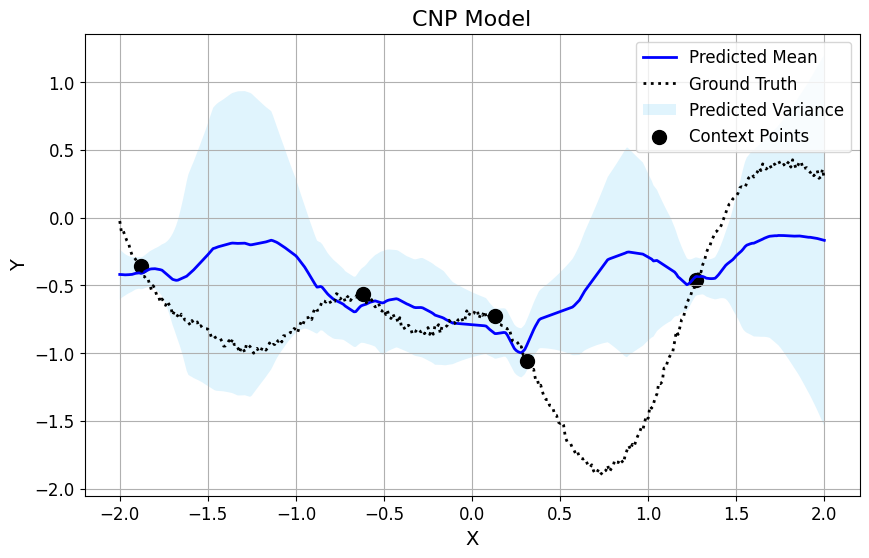

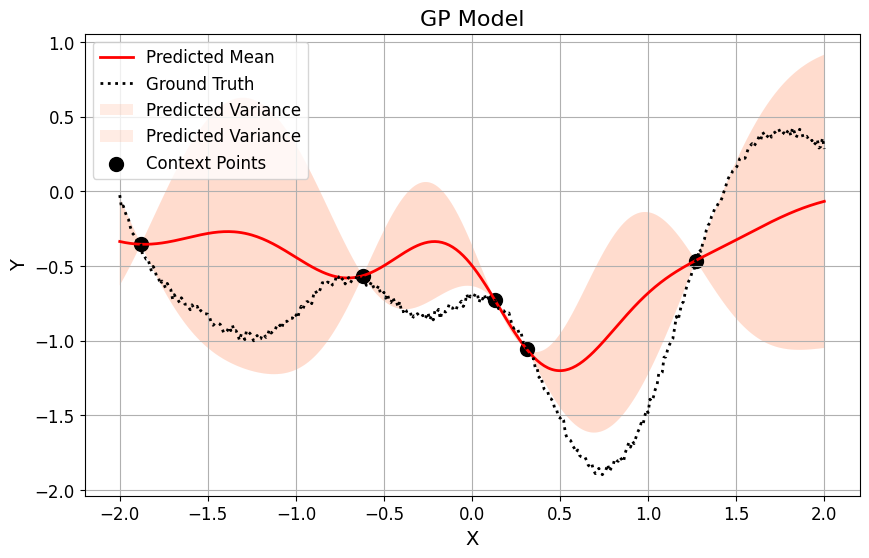

2024-04-23 09:28:58, Iteration: 110000, test loss: 0.7190947532653809


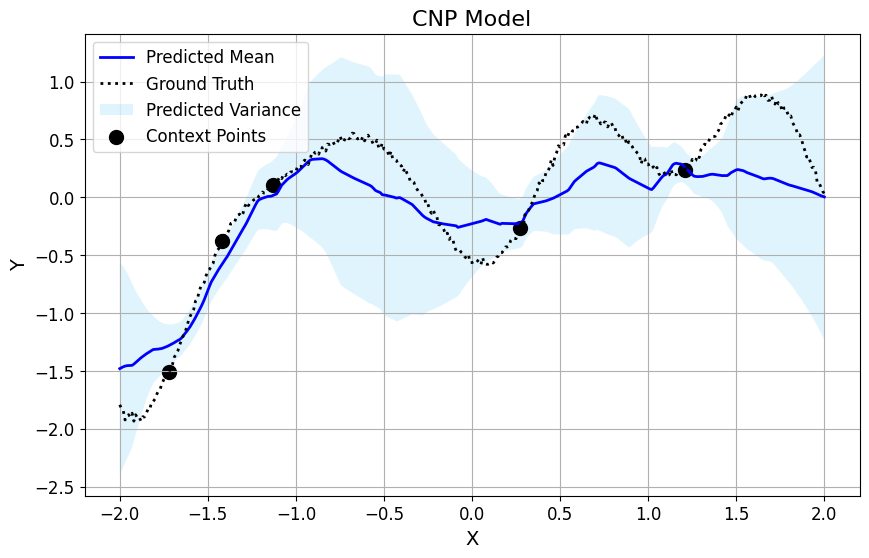

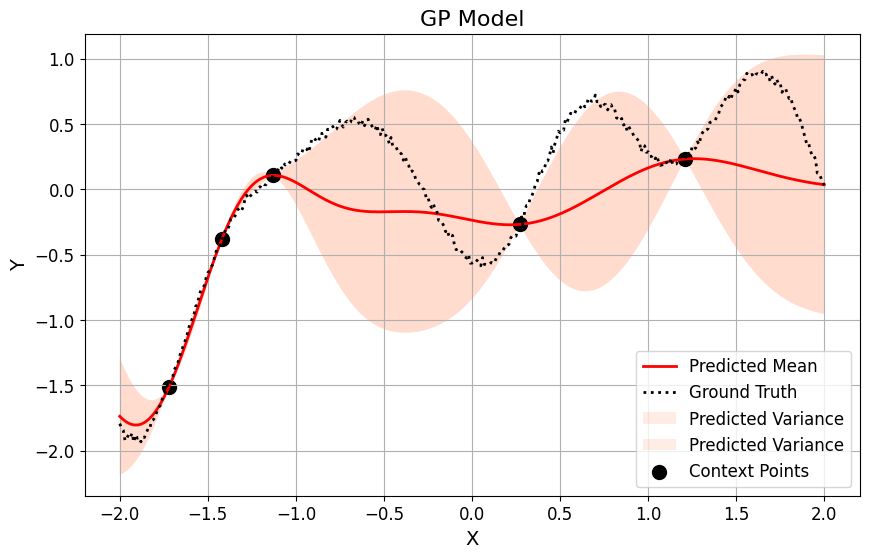

2024-04-23 09:30:54, Iteration: 120000, test loss: 0.5603257417678833


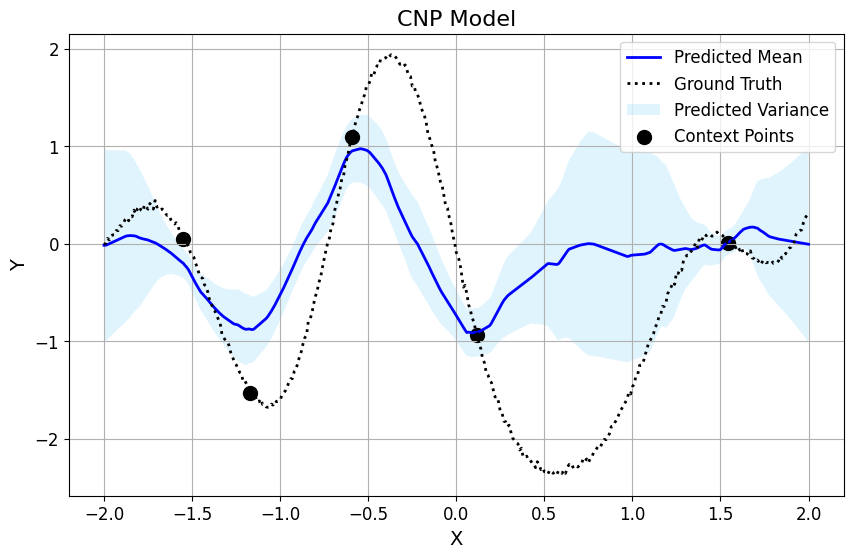

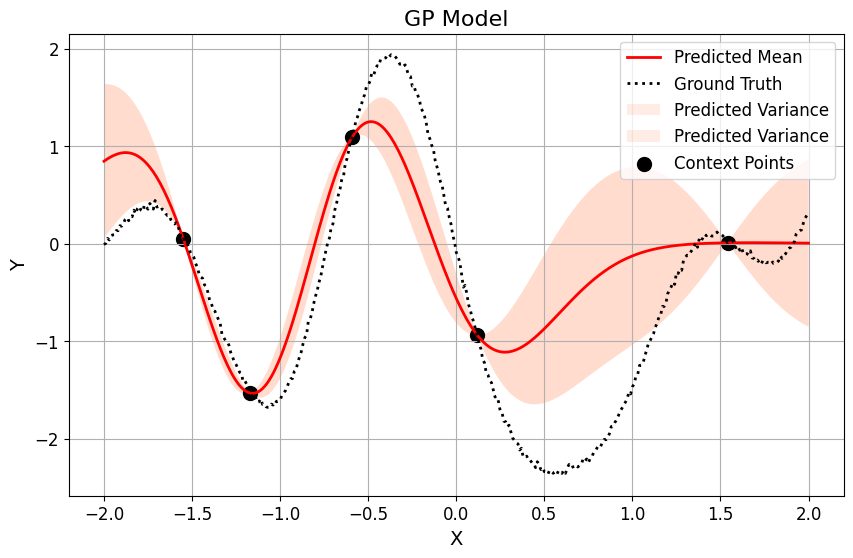

2024-04-23 09:32:50, Iteration: 130000, test loss: 0.6705963015556335


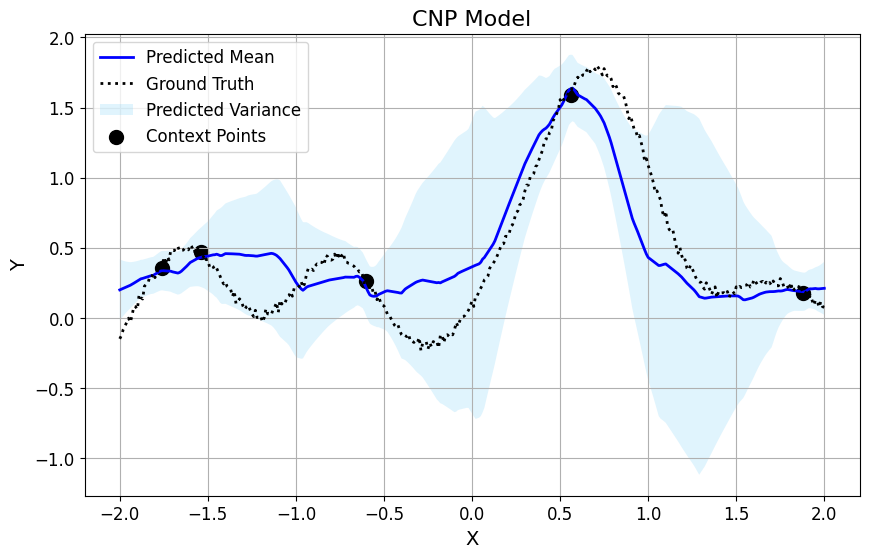

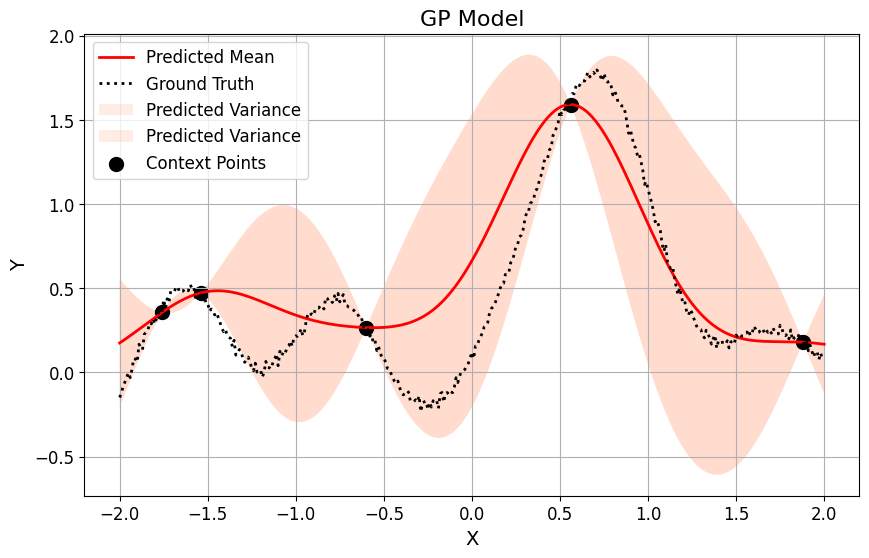

2024-04-23 09:34:45, Iteration: 140000, test loss: 0.5764408111572266


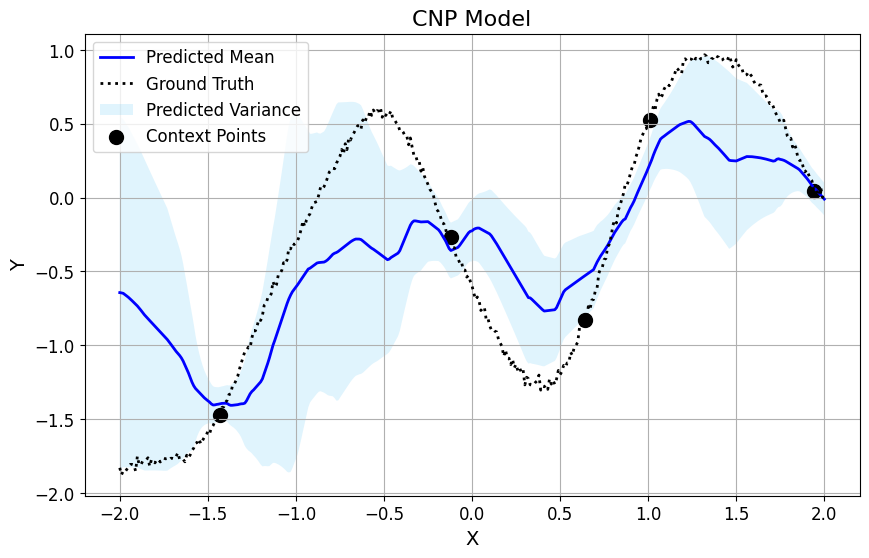

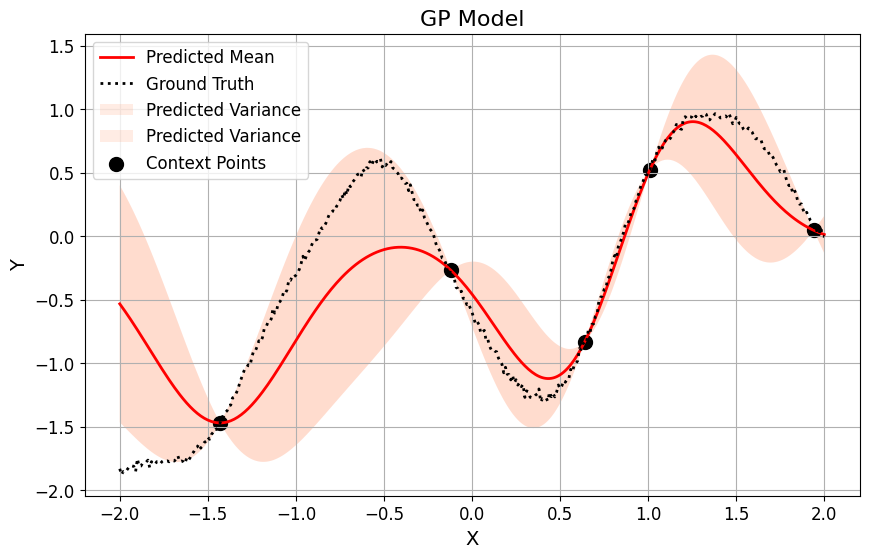

2024-04-23 09:36:44, Iteration: 150000, test loss: 0.7290188074111938


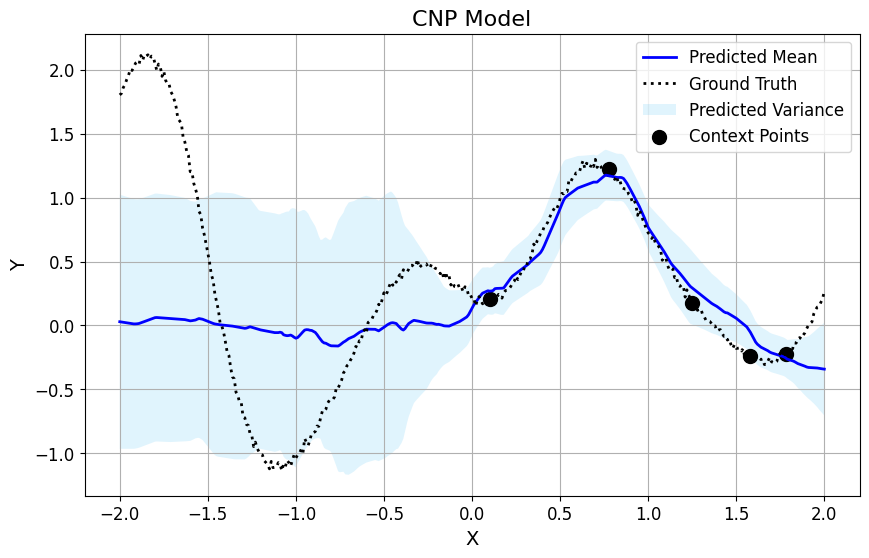

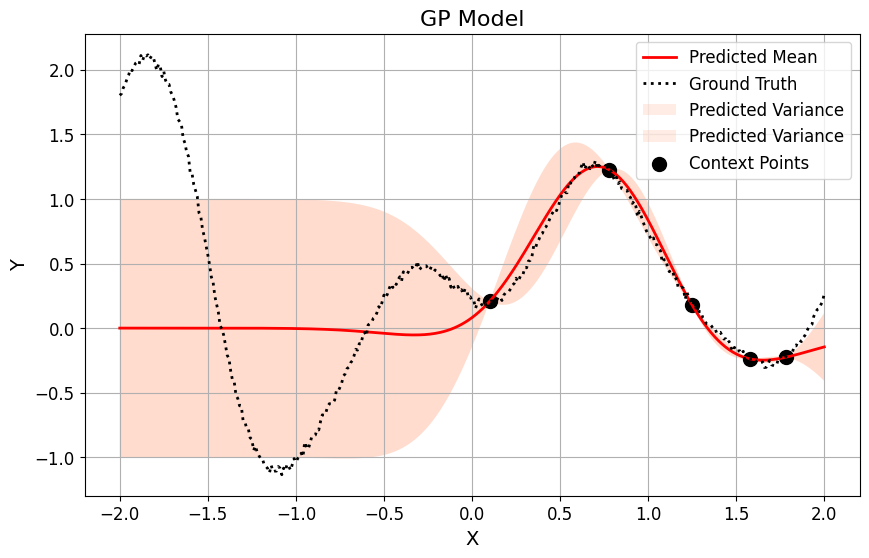

2024-04-23 09:38:39, Iteration: 160000, test loss: 0.7677497863769531


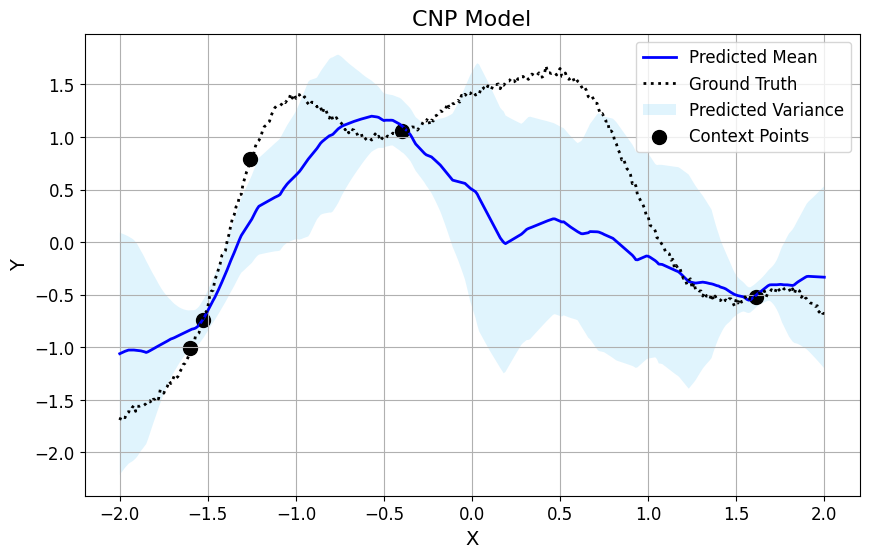

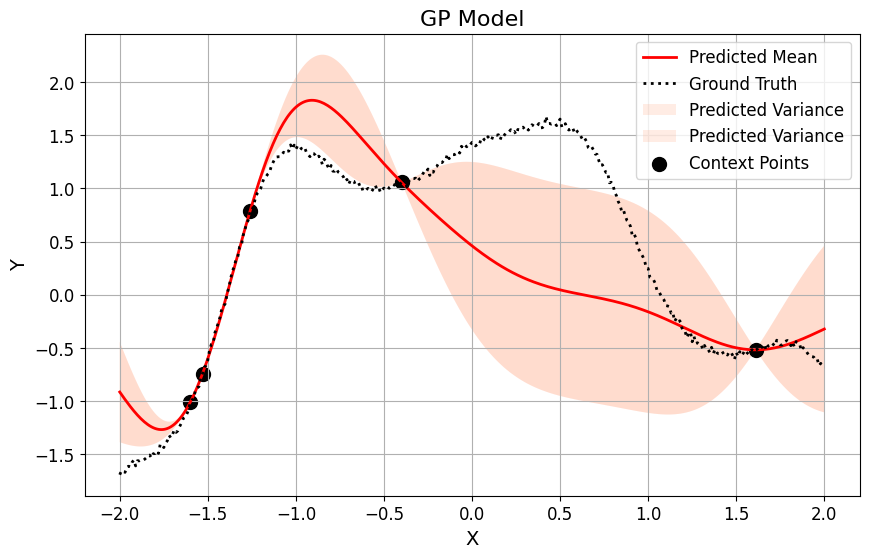

2024-04-23 09:40:34, Iteration: 170000, test loss: 0.8507738709449768


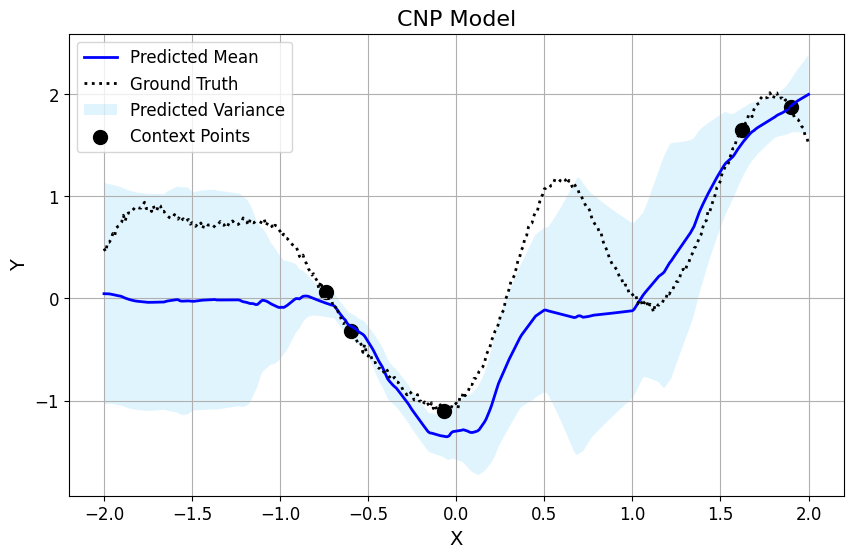

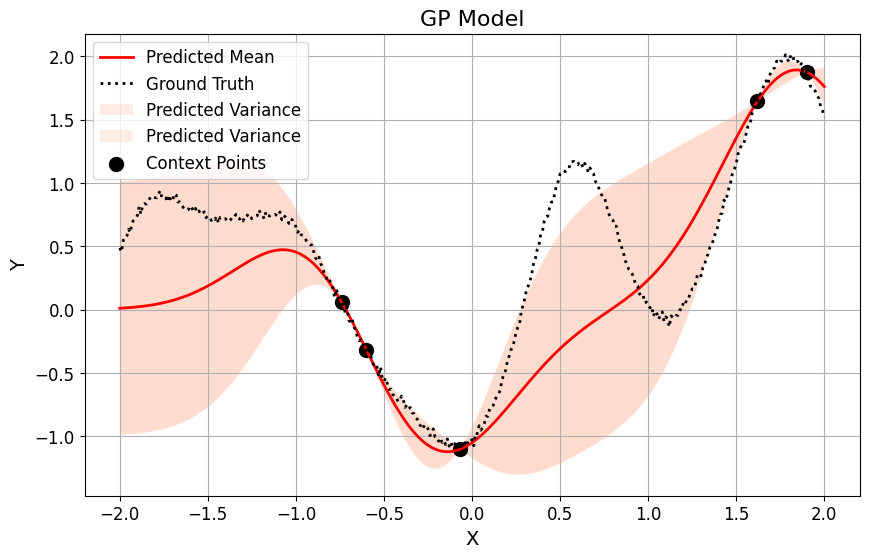

2024-04-23 09:42:31, Iteration: 180000, test loss: 0.6963827013969421


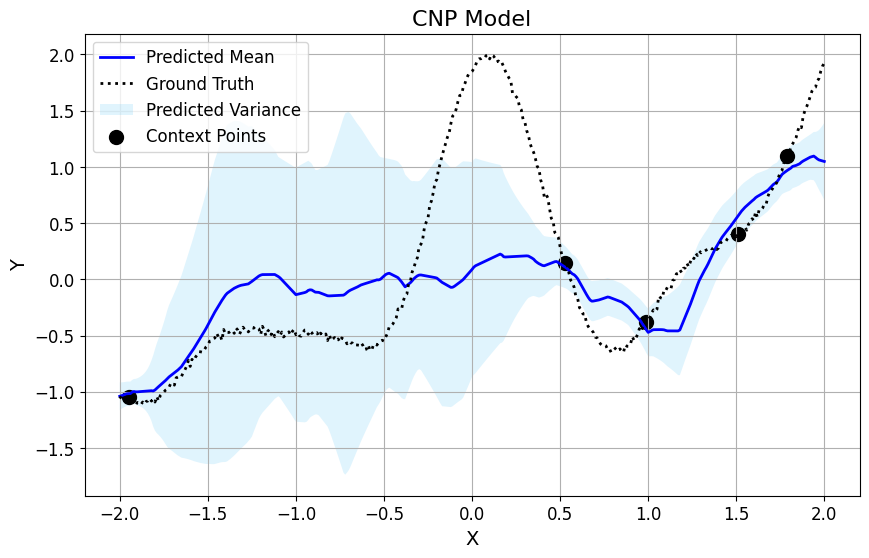

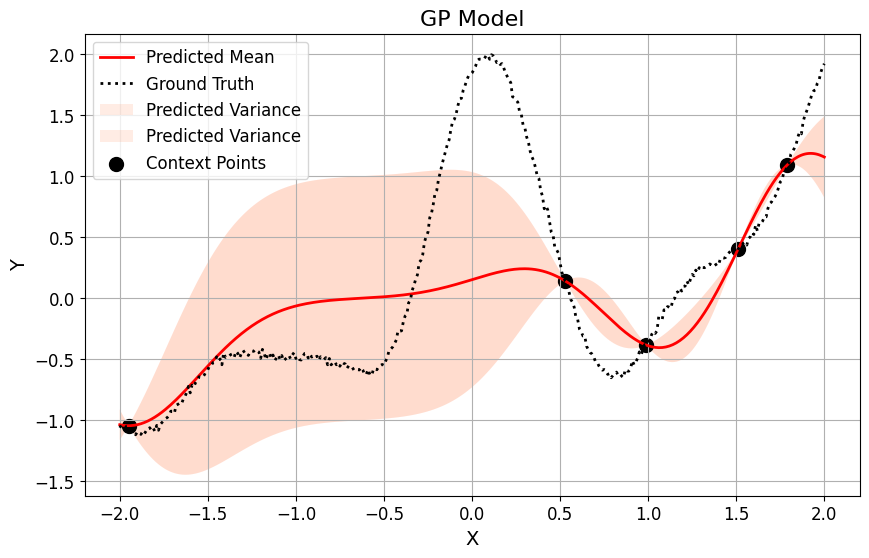

2024-04-23 09:44:25, Iteration: 190000, test loss: 0.835896372795105


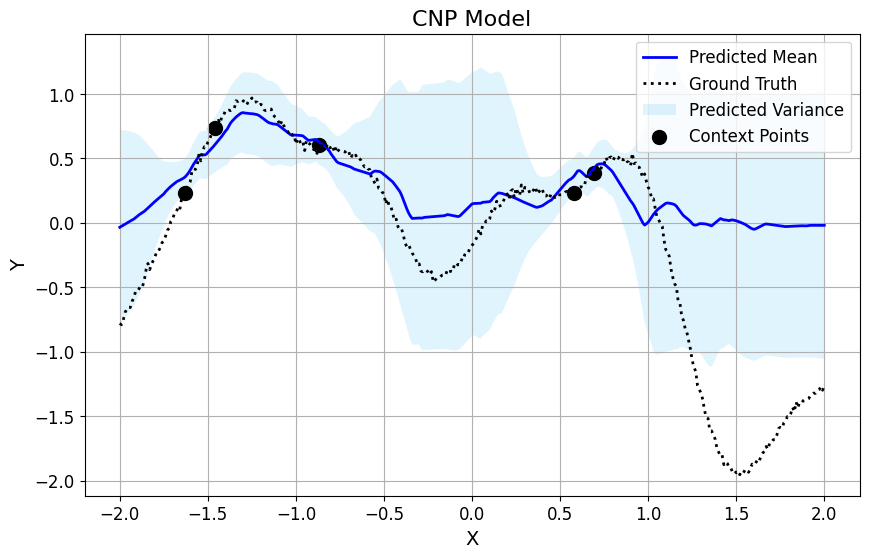

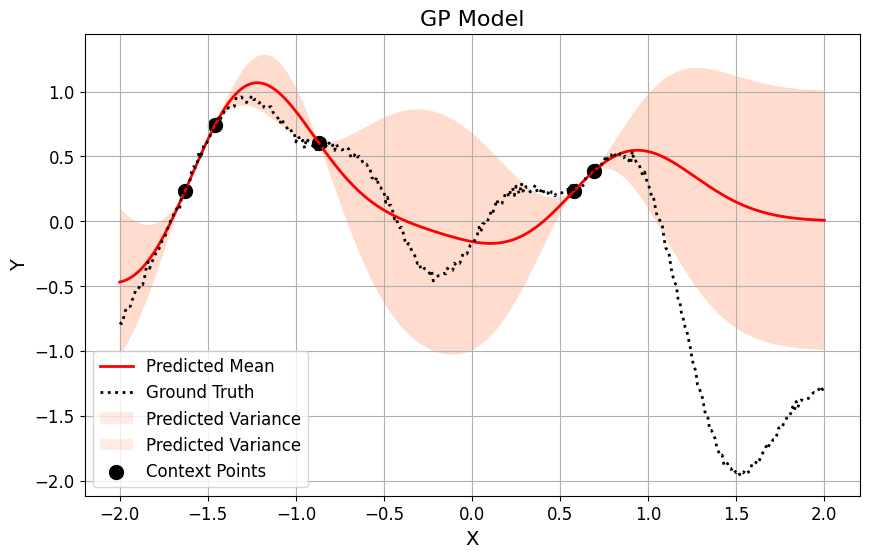

In [ ]:
for it in range(TRAINING_ITERATIONS):
    data_train = dataset_train.generate_curves()
    optimizer.zero_grad()
    log_prob, _, _ = model(data_train.query, data_train.target_y)
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()

    if it % PLOT_AFTER == 0:
        data_test = dataset_test.generate_curves()
        test_log_prob, pred_y, var = model(data_test.query, data_test.target_y)
        test_loss = -test_log_prob.mean()

        print("{}, Iteration: {}, test loss: {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), it, test_loss))
        (context_x, context_y), target_x = data_test.query

        plot_CNP_prediction(target_x.detach().numpy(), data_test.target_y.detach().numpy(), context_x.detach().numpy(), context_y.detach().numpy(), pred_y.detach().numpy(), var.detach().numpy())
        context_x_GP, context_y_GP, target_x_GP = context_x[0, :, 0].numpy(), context_y[0, :, 0].numpy(), target_x[0, :, 0].numpy()
        pred_y_GP, pred_std_GP = GP_predictions(context_y_GP, context_x_GP, target_x_GP, params=[dataset_test._sigma_scale, dataset_test._l1_scale], init_guess=0.0001)
        plot_GP_prediction(target_x.detach().numpy(), data_test.target_y.detach().numpy(), context_x.detach().numpy(), context_y.detach().numpy(), pred_y_GP, pred_std_GP)

2024-04-23 09:46:19, Iteration: 200000, test loss: 0.5501248240470886


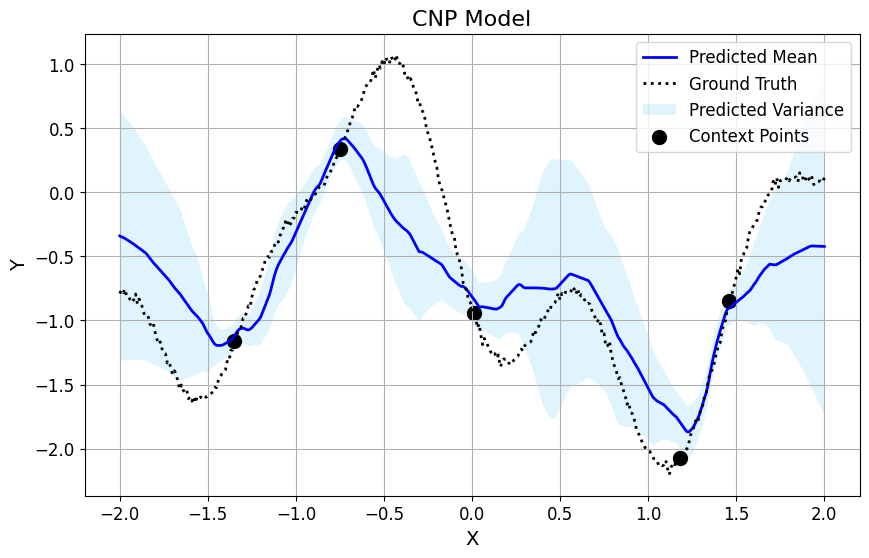

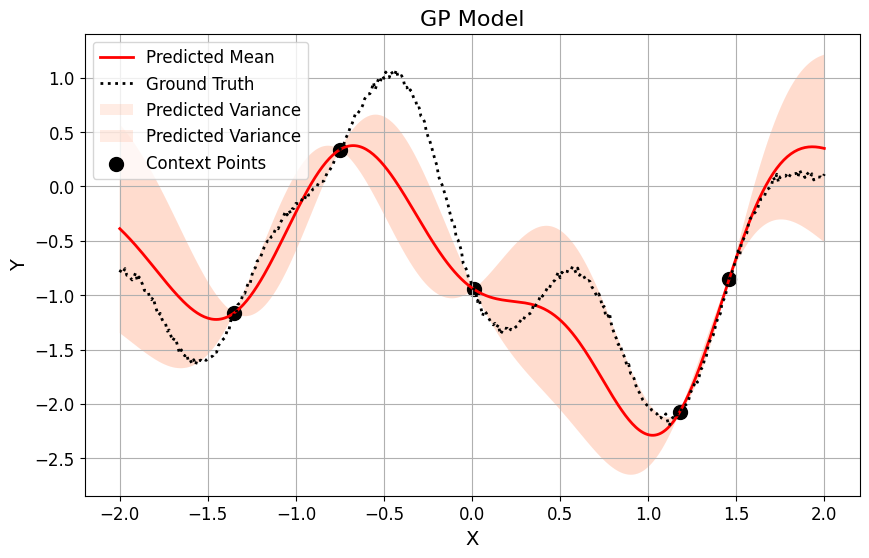

In [ ]:
data_test = dataset_test.generate_curves()
test_log_prob, pred_y, var = model(data_test.query, data_test.target_y)
test_loss = -test_log_prob.mean()

print("{}, Iteration: {}, test loss: {}".format(
    datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), TRAINING_ITERATIONS, test_loss)
)

(context_x, context_y), target_x = data_test.query
plot_CNP_prediction(target_x.detach().numpy(), data_test.target_y.detach().numpy(), context_x.detach().numpy(), context_y.detach().numpy(), pred_y.detach().numpy(), var.detach().numpy())
context_x_GP, context_y_GP, target_x_GP = context_x[0, :, 0].numpy(), context_y[0, :, 0].numpy(), target_x[0, :, 0].numpy()
pred_y_GP, pred_std_GP = GP_predictions(context_y_GP, context_x_GP, target_x_GP, params=[dataset_test._sigma_scale, dataset_test._l1_scale], init_guess=0.0001)
plot_GP_prediction(target_x.detach().numpy(), data_test.target_y.detach().numpy(), context_x.detach().numpy(), context_y.detach().numpy(), pred_y_GP, pred_std_GP)